# Simple Demo

Timing info available as PDF, eg [here](https://assets.lemans.org/explorer/pdf/courses/2019/24-heures-du-mans/classification/race/24-heures-du-mans-2019-classification-after-24h.pdf).

CSV data from Al Kamel using links of form:

`http://fiawec.alkamelsystems.com/Results/08_2018-2019/07_SPA%20FRANCORCHAMPS/267_FIA%20WEC/201905041330_Race/Hour%206/23_Analysis_Race_Hour%206.CSV`


*Links don't seem to appear on e.g. [classification data](http://fiawec.alkamelsystems.com/)? So where else might they be found?*

In [4]:
%matplotlib inline
import pandas as pd

In [5]:
#Add the parent dir to the import path
import sys
sys.path.append("..")

#Import contents of the utils.py package in the parent directory
from py.utils import *

In [6]:
url = 'http://fiawec.alkamelsystems.com/Results/08_2018-2019/07_SPA%20FRANCORCHAMPS/267_FIA%20WEC/201905041330_Race/Hour%206/23_Analysis_Race_Hour%206.CSV'

In [7]:
laptimes = pd.read_csv(url, sep=';').dropna(how='all', axis=1)
laptimes.columns = [c.strip() for c in laptimes.columns]

#Tidy the data a little... car and driver number are not numbers
laptimes[['NUMBER','DRIVER_NUMBER']] = laptimes[['NUMBER','DRIVER_NUMBER']].astype(str)

laptimes.head()

,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,...,S1_LARGE,S2_LARGE,S3_LARGE,TOP_SPEED,DRIVER_NAME,PIT_TIME,CLASS,GROUP,TEAM,MANUFACTURER
0,1,1,1,2:06.349,0,NaN,37.900,0,57.533,0,...,0:37.900,0:57.533,0:30.916,289.0,Neel JANI,NaN,LMP1,NaN,Rebellion Racing,Rebellion
1,1,1,2,2:00.417,0,NaN,34.830,0,54.824,0,...,0:34.830,0:54.824,0:30.763,302.7,Neel JANI,NaN,LMP1,NaN,Rebellion Racing,Rebellion
2,1,1,3,2:17.278,0,B,40.012,0,55.696,0,...,0:40.012,0:55.696,0:41.570,289.0,Neel JANI,NaN,LMP1,NaN,Rebellion Racing,Rebellion
3,1,1,4,3:10.094,0,NaN,1:26.938,0,1:07.045,0,...,1:26.938,1:07.045,0:36.111,262.4,Neel JANI,0:00:58.509,LMP1,NaN,Rebellion Racing,Rebellion
4,1,1,5,2:29.763,0,NaN,41.205,0,1:11.517,0,...,0:41.205,1:11.517,0:37.041,259.2,Neel JANI,NaN,LMP1,NaN,Rebellion Racing,Rebellion


In [8]:
laptimes.columns

Index(['NUMBER', 'DRIVER_NUMBER', 'LAP_NUMBER', 'LAP_TIME', 'LAP_IMPROVEMENT',
       'CROSSING_FINISH_LINE_IN_PIT', 'S1', 'S1_IMPROVEMENT', 'S2',
       'S2_IMPROVEMENT', 'S3', 'S3_IMPROVEMENT', 'KPH', 'ELAPSED', 'HOUR',
       'S1_LARGE', 'S2_LARGE', 'S3_LARGE', 'TOP_SPEED', 'DRIVER_NAME',
       'PIT_TIME', 'CLASS', 'GROUP', 'TEAM', 'MANUFACTURER'],
      dtype='object')

The `DRIVER_NUMBER` is relative to a car. It may be useful to also have a unique driver number, `CAR_DRIVER`:

In [9]:
laptimes['CAR_DRIVER'] = laptimes['NUMBER'] + '_' + laptimes['DRIVER_NUMBER']
laptimes[['NUMBER','DRIVER_NUMBER','CAR_DRIVER']].head()

,NUMBER,DRIVER_NUMBER,CAR_DRIVER
0,1,1,1_1
1,1,1,1_1
2,1,1,1_1
3,1,1,1_1
4,1,1,1_1


## Quick demo chart

Some simple plots to show how we can use widgets etc.

In [10]:
laptimes['LAP_TIME_S'] = laptimes['LAP_TIME'].apply(getTime)
laptimes[['LAP_TIME','LAP_TIME_S']].head()

,LAP_TIME,LAP_TIME_S
0,2:06.349,126.349
1,2:00.417,120.417
2,2:17.278,137.278
3,3:10.094,190.094
4,2:29.763,149.763


In [11]:
from ipywidgets import interact


@interact(number=laptimes['NUMBER'].unique().tolist(),)
def plotLapByNumber(number):
    laptimes[laptimes['NUMBER']==number].plot(x='LAP_NUMBER',y='LAP_TIME_S')

interactive(children=(Dropdown(description='number', options=('1', '11', '17', '26', '28', '29', '3', '31', '3…

In [12]:
@interact(number=laptimes['NUMBER'].unique().tolist(),)
def plotLapByNumberDriver(number):
    # We can pivot long to wide on driver number, then plot all cols against the lapnumber index
    laptimes[laptimes['NUMBER']==number].pivot(index='LAP_NUMBER',columns='DRIVER_NUMBER', values='LAP_TIME_S').plot()


interactive(children=(Dropdown(description='number', options=('1', '11', '17', '26', '28', '29', '3', '31', '3…

In [13]:
@interact(number=laptimes['NUMBER'].unique().tolist(),)
def plotLapByNumberDriverWithPit(number):
    # We can pivot long to wide on driver number, then plot all cols against the lapnumber index
    #Grap the matplotli axes so we can overplot onto them
    ax = laptimes[laptimes['NUMBER']==number].pivot(index='LAP_NUMBER',columns='DRIVER_NUMBER', values='LAP_TIME_S').plot()
    #Also add in pit laps
    laptimes[(laptimes['NUMBER']==number) & (laptimes['CROSSING_FINISH_LINE_IN_PIT']=='B')].plot.scatter(x='LAP_NUMBER',y='LAP_TIME_S', ax=ax)
    

interactive(children=(Dropdown(description='number', options=('1', '11', '17', '26', '28', '29', '3', '31', '3…

## Stint Detection

Some simple heuristics for detecting stints:

- car stint: between each pit stop;
- driver session: session equates to continuous period in car;
- driver stint: relative to pit stops; this may be renumbered for each session?

In [14]:
#Driver session

#Create a flag to identify when we enter the pit, aka an INLAP
laptimes['INLAP'] = laptimes['CROSSING_FINISH_LINE_IN_PIT'] == 'B'

#Make no assumptions about table order - so sort by lap number
laptimes = laptimes.sort_values(['NUMBER','LAP_NUMBER'])

# Identify a new stint for each car by sifting the pitting / INLAP flag within car tables
laptimes['OUTLAP'] = laptimes.groupby('NUMBER')['INLAP'].shift(fill_value=True)

laptimes[['DRIVER_NUMBER', 'INLAP','OUTLAP']].head()

,DRIVER_NUMBER,INLAP,OUTLAP
0,1,False,True
1,1,False,False
2,1,True,False
3,1,False,True
4,1,False,False


In [15]:
#This is a count of the number of times a driver is in a vehicle after a pit who wasn't in it before
#Also set overall lap = 1 to be a driver change
laptimes['driverchange'] = (~laptimes['DRIVER_NUMBER'].eq(laptimes['DRIVER_NUMBER'].shift())) | (laptimes['LAP_NUMBER']==1)

laptimes['DRIVER_SESSION'] = laptimes.groupby(['NUMBER', 'DRIVER_NUMBER'])['driverchange'].cumsum().astype(int)
laptimes[['DRIVER_NUMBER', 'driverchange','DRIVER_SESSION','LAP_NUMBER']][42:48]

,DRIVER_NUMBER,driverchange,DRIVER_SESSION,LAP_NUMBER
42,1,False,1,43
43,1,False,1,44
44,1,False,1,45
45,2,True,1,46
46,2,False,1,47
47,2,False,1,48


In [16]:
# Car stint
#Create a counter for each pit stop - the pit flag is entering pit at end of stint
#  so a new stint applies on the lap after a pit
#Find the car stint based on count of pit stops
laptimes['CAR_STINT'] = laptimes.groupby('NUMBER')['OUTLAP'].cumsum().astype(int)

laptimes[['CROSSING_FINISH_LINE_IN_PIT', 'INLAP', 'OUTLAP', 'CAR_STINT']].head()

,CROSSING_FINISH_LINE_IN_PIT,INLAP,OUTLAP,CAR_STINT
0,NaN,False,True,1
1,NaN,False,False,1
2,B,True,False,1
3,NaN,False,True,2
4,NaN,False,False,2


In [17]:
#Driver stint - a cumulative count for each driver of their stints
laptimes['DRIVER_STINT'] = laptimes.groupby('CAR_DRIVER')['OUTLAP'].cumsum().astype(int)

#Let's also derive another identifier - CAR_DRIVER_STINT
laptimes['CAR_DRIVER_STINT'] = laptimes['CAR_DRIVER'] + '_' + laptimes['DRIVER_STINT'].astype(str)

laptimes[['CAR_DRIVER', 'CROSSING_FINISH_LINE_IN_PIT', 'INLAP','CAR_STINT', 'DRIVER_STINT', 'CAR_DRIVER_STINT']].tail(20).head(10)


,CAR_DRIVER,CROSSING_FINISH_LINE_IN_PIT,INLAP,CAR_STINT,DRIVER_STINT,CAR_DRIVER_STINT
4212,98_2,NaN,False,7,1,98_2_1
4213,98_2,NaN,False,7,1,98_2_1
4214,98_2,NaN,False,7,1,98_2_1
4215,98_2,NaN,False,7,1,98_2_1
4216,98_2,NaN,False,7,1,98_2_1
4217,98_2,B,True,7,1,98_2_1
4218,98_2,NaN,False,8,2,98_2_2
4219,98_2,NaN,False,8,2,98_2_2
4220,98_2,NaN,False,8,2,98_2_2
4221,98_2,NaN,False,8,2,98_2_2


In [18]:
#Driver session stint - a count for each driver of their stints within a particular driving session
laptimes['DRIVER_SESSION_STINT'] = laptimes.groupby(['CAR_DRIVER','DRIVER_SESSION'])['OUTLAP'].cumsum().astype(int)
laptimes[['CAR_DRIVER', 'CROSSING_FINISH_LINE_IN_PIT', 'INLAP','CAR_STINT', 'DRIVER_STINT', 'CAR_DRIVER_STINT', 'DRIVER_SESSION_STINT']].head()


,CAR_DRIVER,CROSSING_FINISH_LINE_IN_PIT,INLAP,CAR_STINT,DRIVER_STINT,CAR_DRIVER_STINT,DRIVER_SESSION_STINT
0,1_1,NaN,False,1,1,1_1_1,1
1,1_1,NaN,False,1,1,1_1_1,1
2,1_1,B,True,1,1,1_1_1,1
3,1_1,NaN,False,2,2,1_1_2,2
4,1_1,NaN,False,2,2,1_1_2,2


## Lap Counts Within Stints

It may be convenient to keep track of lap counts within stints.

In [19]:
# lap count by car stint - that is, between each pit stop
laptimes['LAPS_CAR_STINT'] = laptimes.groupby(['NUMBER','CAR_STINT']).cumcount()+1

#lap count by driver
laptimes['LAPS_DRIVER'] = laptimes.groupby('CAR_DRIVER').cumcount()+1

#lap count by driver session
laptimes['LAPS_DRIVER_SESSION'] = laptimes.groupby(['CAR_DRIVER','DRIVER_SESSION']).cumcount()+1

#lap count by driver stint
laptimes['LAPS_DRIVER_STINT'] = laptimes.groupby(['CAR_DRIVER','DRIVER_STINT']).cumcount()+1

laptimes[['LAPS_CAR_STINT', 'LAPS_DRIVER', 'LAPS_DRIVER_SESSION', 'LAPS_DRIVER_STINT']].tail()

,LAPS_CAR_STINT,LAPS_DRIVER,LAPS_DRIVER_SESSION,LAPS_DRIVER_STINT
4227,10,16,16,10
4228,11,17,17,11
4229,12,18,18,12
4230,13,19,19,13
4231,14,20,20,14


## Basic Individal Driver Reports

Using those additional columns, we should be able to start creating reports by driver by facetting on individual drivers.

(Note: it might be interesting to do some datasette demos with particular facets, which make it easy to select teams, drivers, etc.)

In [20]:
import qgrid
qgrid.show_grid(laptimes[['LAP_NUMBER', 'NUMBER', 'CAR_DRIVER',  'INLAP', 'CAR_STINT', 
                          'CAR_DRIVER_STINT', 'DRIVER_STINT', 'DRIVER_SESSION', 'DRIVER_SESSION_STINT']])

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Simple Stint Reports

Using the various stint details, we can pull together a simple set of widgets to allow us to explore times by car / driver.

In [21]:
import ipywidgets as widgets
from ipywidgets import interact

In [22]:
cars = widgets.Dropdown(
    options=laptimes['NUMBER'].unique(), # value='1',
    description='Car:', disabled=False )

drivers = widgets.Dropdown(
    options=laptimes[laptimes['NUMBER']==cars.value]['CAR_DRIVER'].unique(),
    description='Driver:', disabled=False)

driversessions = widgets.Dropdown(
    options=laptimes[laptimes['CAR_DRIVER']==drivers.value]['DRIVER_SESSION'].unique(),
    description='Session:', disabled=False)

driverstints = widgets.Dropdown(
    options=laptimes[laptimes['DRIVER_SESSION']==driversessions.value]['DRIVER_SESSION_STINT'].unique(),
    description='Stint:', disabled=False)

def update_drivers(*args):
    driverlist = laptimes[laptimes['NUMBER']==cars.value]['CAR_DRIVER'].unique()
    drivers.options = driverlist
    
def update_driver_session(*args):
    driversessionlist = laptimes[(laptimes['CAR_DRIVER']==drivers.value)]['DRIVER_SESSION'].unique()
    driversessions.options = driversessionlist
    
def update_driver_stint(*args):
    driverstintlist = laptimes[(laptimes['CAR_DRIVER']==drivers.value) &
                               (laptimes['DRIVER_SESSION']==driversessions.value)]['DRIVER_SESSION_STINT'].unique()
    driverstints.options = driverstintlist
    
cars.observe(update_drivers, 'value')
drivers.observe(update_driver_session,'value')
driversessions.observe(update_driver_stint,'value')

def laptime_table(car, driver, driversession, driverstint):
    #just basic for now...
    display(laptimes[(laptimes['CAR_DRIVER']==driver) &
                     (laptimes['DRIVER_SESSION']==driversession) &
                     (laptimes['DRIVER_SESSION_STINT']==driverstint) ][['CAR_DRIVER', 'DRIVER_SESSION',
                                                         'DRIVER_STINT', 'DRIVER_SESSION_STINT',
                                                         'LAP_NUMBER','LAP_TIME', 'LAP_TIME_S']])
    
interact(laptime_table, car=cars, driver=drivers, driversession=driversessions, driverstint=driverstints);


interactive(children=(Dropdown(description='Car:', options=('1', '11', '17', '26', '28', '29', '3', '31', '36'…

In [23]:
def laptime_chart(car, driver, driversession, driverstint):
    tmp_df = laptimes[(laptimes['CAR_DRIVER']==driver) &
                     (laptimes['DRIVER_SESSION']==driversession) &
                     (laptimes['DRIVER_SESSION_STINT']==driverstint) ][['CAR_DRIVER', 'DRIVER_SESSION',
                                                         'DRIVER_STINT', 'DRIVER_SESSION_STINT',
                                                         'LAP_NUMBER','LAP_TIME', 'LAP_TIME_S']]['LAP_TIME_S'].reset_index(drop=True)
    if not tmp_df.empty:
        tmp_df.plot()
        
interact(laptime_chart, car=cars, driver=drivers, driversession=driversessions, driverstint=driverstints);


interactive(children=(Dropdown(description='Car:', options=('1', '11', '17', '26', '28', '29', '3', '31', '36'…

In [25]:
#Also add check boxes to suppress inlap and outlap?
inlaps = widgets.Checkbox( value=True, description='Inlap',
                           disabled=False )

outlaps = widgets.Checkbox( value=True, description='Outlap',
                           disabled=False )


#Plot laptimes by stint for a specified driver
def laptime_charts(car, driver, driversession, inlap, outlap):
    tmp_df = laptimes
    
    if not inlap:
        tmp_df = tmp_df[~tmp_df['INLAP']]
    if not outlap:
        tmp_df = tmp_df[~tmp_df['OUTLAP']]
        
    tmp_df = tmp_df[(tmp_df['CAR_DRIVER']==driver) &
                     (tmp_df['DRIVER_SESSION']==driversession) ].pivot(index='LAPS_DRIVER_STINT',
                                                                       columns='DRIVER_SESSION_STINT', 
                                                                       values='LAP_TIME_S').reset_index(drop=True)
    
    if not tmp_df.empty:
        tmp_df.plot()



interact(laptime_charts, car=cars, driver=drivers, driversession=driversessions, inlap=inlaps, outlap=outlaps);



interactive(children=(Dropdown(description='Car:', options=('1', '11', '17', '26', '28', '29', '3', '31', '36'…

## Simple Model

An example of creating a simple model using some explcitly pulled out data.

In [26]:
def sample_laptimes(df, driver,driversession,driversessionstint=None, inlap=False, outlap=False):
    df = df[(df['CAR_DRIVER']==driver) & (df['DRIVER_SESSION']== driversession)]
    if not inlap:
        df = df[~df['INLAP']]
    if not outlap:
        df = df[~df['OUTLAP']]
        
    if driversessionstint:
        return df[df['DRIVER_SESSION_STINT']==driversessionstint]['LAP_TIME_S']
    
    return df.pivot(index='LAPS_DRIVER_STINT',
                    columns='DRIVER_SESSION_STINT',
                    values='LAP_TIME_S').reset_index(drop=True)

sample_laptimes(laptimes,'56_1', 1, 2)

1966    161.049
1967    157.612
1968    155.005
1969    153.755
1970    153.441
1971    153.001
1972    154.286
1973    153.666
1974    153.946
1975    153.746
1976    153.142
1977    153.546
1978    153.825
1979    154.792
1980    152.768
1981    153.556
1982    157.151
1983    159.646
1984    157.560
1985    172.857
1986    215.284
1987    300.466
1988    231.624
Name: LAP_TIME_S, dtype: float64

### Some Simple Linear Models

Fitted without explanation... we should only accept models that appear to fit, i.e. that have a low error...

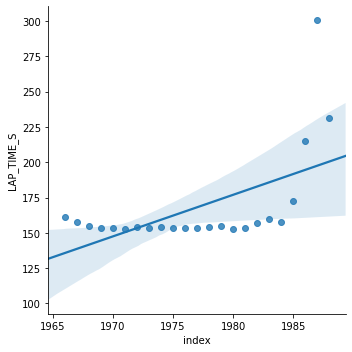

In [64]:
import seaborn as sns

sns.lmplot(x='index', y='LAP_TIME_S', data=sample_laptimes(laptimes,'56_1', 1, 2).reset_index());


We can also increase the order of the fit line (the `ci` parameter toggles the confidence bounds display):

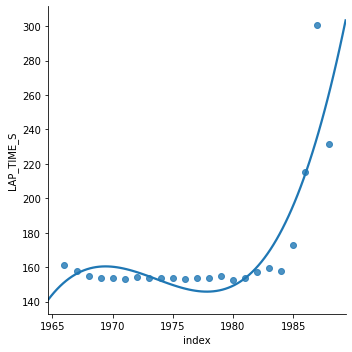

In [67]:
sns.lmplot(x='index', y='LAP_TIME_S', data=sample_laptimes(laptimes,'56_1', 1, 2).reset_index(),
           order = 2, ci=None);


In [58]:
#Simple model
import statsmodels.api as sm


Y = sample_laptimes(laptimes,'56_1', 1, 2).reset_index(drop=True)
X = Y.index.values
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:             LAP_TIME_S   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     10.05
Date:                Sun, 30 Jun 2019   Prob (F-statistic):            0.00462
Time:                        23:42:49   Log-Likelihood:                -109.49
No. Observations:                  23   AIC:                             223.0
Df Residuals:                      21   BIC:                             225.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        135.6617     11.942     11.360      0.0

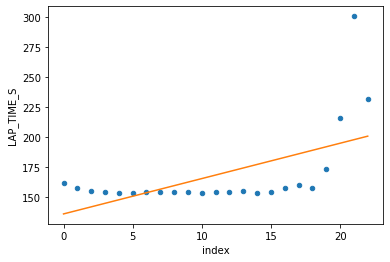

In [63]:
p = model.params

ax = pd.DataFrame(Y).reset_index().plot(kind='scatter', x='index', y='LAP_TIME_S')
ax.plot(X, p.const + p.x1 * X);

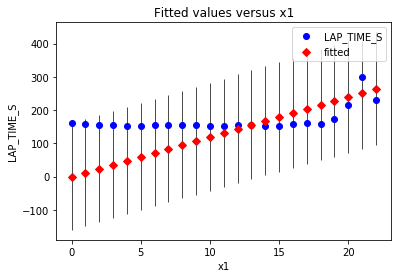

In [51]:
import matplotlib.pyplot as plt

# scatter-plot data
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(model, 0, ax=ax)

## Simple Position Calculations

Some simple demonstrations of calculating position data.

Naively, calculate position based on lap number and accumulated time (there may be complications based on whether the lead car records a laptine from pit entry...).

In [22]:
#Find accumulated time in seconds
laptimes['ELAPSED_S']=laptimes['ELAPSED'].apply(getTime)


#Check
laptimes['CHECK_ELAPSED_S'] = laptimes.groupby('NUMBER')['LAP_TIME_S'].cumsum()

laptimes[['ELAPSED','ELAPSED_S','CHECK_ELAPSED_S']].tail()

,ELAPSED,ELAPSED_S,CHECK_ELAPSED_S
4227,5:30:09.132,19809.132,19809.132
4228,5:34:28.852,20068.852,20068.852
4229,5:38:03.099,20283.099,20283.099
4230,5:41:23.769,20483.769,20483.769
4231,5:44:49.972,20689.972,20689.972


We can use the position to identify the leader on each lap and from that a count of leadlap number for each car:

In [23]:
#Find position based on accumulated laptime
laptimes = laptimes.sort_values('ELAPSED_S')
laptimes['POS'] = laptimes.groupby('LAP_NUMBER')['ELAPSED_S'].rank()

#Find leader naively
laptimes['leader'] = laptimes['POS']==1

#Find lead lap number
laptimes['LEAD_LAP_NUMBER'] = laptimes['leader'].cumsum()

laptimes[['LAP_NUMBER','LEAD_LAP_NUMBER']].tail()

,LAP_NUMBER,LEAD_LAP_NUMBER
2629,120,133
1293,127,133
1517,95,133
3377,121,133
1643,126,133


## Simple Position Chart - Top 10 At End

Find last lap number, then get top 10 on that lap.

In [32]:
LAST_LAP = laptimes['LEAD_LAP_NUMBER'].max()
LAST_LAP

133

In [35]:
#Find top 10 at end
cols = ['NUMBER','TEAM', 'DRIVER_NAME', 'CLASS','LAP_NUMBER','ELAPSED']
laptimes[laptimes['LEAD_LAP_NUMBER']==LAST_LAP].sort_values(['LEAD_LAP_NUMBER', 'POS'])[cols].head(10)


,NUMBER,TEAM,DRIVER_NAME,CLASS,LAP_NUMBER,ELAPSED
3008,8,Toyota Gazoo Racing,Fernando ALONSO,LMP1,133,5:44:41.101
908,3,Rebellion Racing,Thomas LAURENT,LMP1,132,5:44:58.794
261,11,SMP Racing,Mikhail ALESHIN,LMP1,132,5:45:05.350
392,17,SMP Racing,Sergey SIROTKIN,LMP1,131,5:45:01.895
129,1,Rebellion Racing,Bruno SENNA,LMP1,130,5:44:44.193
2509,7,Toyota Gazoo Racing,Kamui KOBAYASHI,LMP1,129,5:44:45.682
1037,31,DragonSpeed,Pastor MALDONADO,LMP2,129,5:44:55.919
521,26,G-Drive Racing,Jean-Eric VERGNE,LMP2,129,5:44:59.874
1166,36,Signatech Alpine Matmut,Nicolas LAPIERRE,LMP2,129,5:45:00.351
1422,38,Jackie Chan DC Racing,Gabriel AUBRY,LMP2,129,5:45:04.546


In [30]:
laptimes.columns

Index(['NUMBER', 'DRIVER_NUMBER', 'LAP_NUMBER', 'LAP_TIME', 'LAP_IMPROVEMENT',
       'CROSSING_FINISH_LINE_IN_PIT', 'S1', 'S1_IMPROVEMENT', 'S2',
       'S2_IMPROVEMENT', 'S3', 'S3_IMPROVEMENT', 'KPH', 'ELAPSED', 'HOUR',
       'S1_LARGE', 'S2_LARGE', 'S3_LARGE', 'TOP_SPEED', 'DRIVER_NAME',
       'PIT_TIME', 'CLASS', 'GROUP', 'TEAM', 'MANUFACTURER', 'CAR_DRIVER',
       'LAP_TIME_S', 'INLAP', 'OUTLAP', 'driverchange', 'DRIVER_SESSION',
       'CAR_STINT', 'DRIVER_STINT', 'CAR_DRIVER_STINT', 'DRIVER_SESSION_STINT',
       'LAPS_CAR_STINT', 'LAPS_DRIVER', 'LAPS_DRIVER_SESSION',
       'LAPS_DRIVER_STINT', 'ELAPSED_S', 'CHECK_ELAPSED_S', 'POS', 'leader',
       'LEAD_LAP_NUMBER'],
      dtype='object')